## Project Steps

1. Choose the feature representation that best serves the purpose of distinguishing between the two classes - cars and not cars - For this, I chose 3 feature representation methods and concatenate all 3 to form a single feature vector. 
    * Spatial arrangement of color in the image - HSV color space
    * Histogram of color in the image - HSV color space
    * HOG (Histogram of Gradient Features) - All 3 channels of the input.
2. Train a linear classifier (SVM chosen here since it has been shown to work well with HOG features in literature) for the features obtained above.
3. Given a new test image, run multiple proposals(windows) and classify them proposals as one or the other class. 
4. To ensure not to miss out on detecting a car object in the image, the proposals checked for 'carness' have to be of varying sizes and spread throughout the viable region of the image where we expect to see cars.
5. Using a simple heatmap technique sum up the multiple overlapping detections (bound to happen because of step 4) and obtain a maximal window which summarizes all overlapping windows for each object.
6. Once the image processing pipeline is ready, process the test video.


### Each of the steps individually have a short writeup below. The blocks succeeding the writeup are the code cells which perform the required steps.

### 1. Define functions required to extract features

Here I use the below defined functions, bin_spatial to extract color values of the image, color_hist to obtain the color histogram of the image, and get_hog_featues to get HOG features of the image.

As described in the lecture, the RGB color space doesn't give us much information to differentiate car images from non car images. But, HSV space, does give this discrimnatory capability in the S channel. Hence, I choose to use HSV color space.

Parameters used:
    * 32*32 : size for getting color values of the image.
    * 32 : histogram bin size

Below are the HOG parameters used. orientation, pix_per_cell and cell_per_block are standard values recommended across literature and, they also happen to be the parameters used as default in udacity lectures. for hog_channel, I got highest accuracy in SVM classifier with hog_channel set to 'ALL'. Hence, I use 'ALL' for hog channel.
    * orient = 9
    * pix_per_cell = 8
    * cell_per_block = 2
    * hog_channel = 'ALL'

In [38]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from skimage.feature import hog

%matplotlib inline

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
    # Return list of feature vectors
    return features

In [28]:
# Read in all car images
cars = glob.glob('./vehicles/GTI_Far/*.*')
cars.extend(glob.glob('./vehicles/GTI_Left/*.*'))
cars.extend(glob.glob('./vehicles/GTI_MiddleClose/*.*'))
cars.extend(glob.glob('./vehicles/GTI_Right/*.*'))
cars.extend(glob.glob('./vehicles/KITTI_extracted/*.*'))

In [29]:
#Read in all non car images
notcars = glob.glob('./non-vehicles/Extras/*.*')
notcars.extend(glob.glob('./non-vehicles/GTI/*.*'))

In [30]:
#Check the relative sizes of cars and notcars datasets
print('Number of examples of car class : ', len(cars))
print('Number of examples of notcar class :', len(notcars))

Number of examples of car class :  8792
Number of examples of notcar class : 8968


#### The number of examples for each class are very much similar. This ensures that the classifier is not biased towards one class. So, we leave the dataset as it is.

In [44]:
#Extract features using the functions defined above.
#Some hyperparameters need to be tuned as like in any machine learning algorithm.

spatial = 32
histbin = 32

orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

print ('start extracting features')

car_features = extract_features(cars, cspace='HSV', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256),orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace='HSV', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256),orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

print('completed extracting features')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
#The randomness introduced here is enough for shuffling the data
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

start extracting features
completed extracting features
size of feature vector :  8460
6.04 Seconds to train SVC...
Test Accuracy of SVC =  0.9885


In [128]:
#Testing the distribution of classes in train and test datasets
print('Training dataset distribution')
unique_train, counts_train = np.unique(y_train, return_counts=True)
print(dict(zip(unique_train, counts_train)))

print('Test dataset distribution')
unique_test, counts_test = np.unique(y_test, return_counts=True)
print(dict(zip(unique_test, counts_test)))

Training dataset distribution
{0.0: 7196, 1.0: 7012}
Test dataset distribution
{0.0: 1772, 1.0: 1780}


#### The train and test datasets are not skewed in any one class's direction. All set to train the SVM classifier!

### 2. Train SVM Classifier

Once, we have the features split into the train and test datasets, and we have verified that both test and train datasets are not biased towards any particular class in terms of examples of that class in them, we can go ahead and train the SVM classifier. The code for the same is as below.

In [51]:
#Size of feature vector
print('size of feature vector : ', X_train[0].size)
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

size of feature vector :  8460
6.89 Seconds to train SVC...
Test Accuracy of SVC =  0.9885


### accuracy values obtained for different features
* Spatial color and color histogram - test accuracy of 88%
* Spatial color and color histogram and one channel of HOG - test accuracy of ~94%
* Spatial color and color histogram and 3 channels of HOG - test accuracy of 98.85%
* We will choose the highest accuracy feature vector (a vector of length 8460) for training our classifier.


In [423]:
#Saving the dataset
#Load later if necessary

import pickle

pickle_file = 'train_test_data.p'
save_dict = {'train_dataset':X_train, 'train_labels':y_train, 'test_dataset':X_test,
             'test_labels': y_test, 'X_scaler': X_scaler}
try:
    with open(pickle_file, 'wb') as file:
        pickle.dump(save_dict,file,protocol=pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', pickle_file, ':', 'exception:', e)

In [455]:
#Function that produces different proposals(sliding windows)

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Function used to visualize
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


### 3. Check and finetune the pipeline on a test image

Here, we use the helper functions defined above for coming up with a pipeline to process an image and to finetune the pipeline in terms of size of the windows, and placement of the windows in the image.

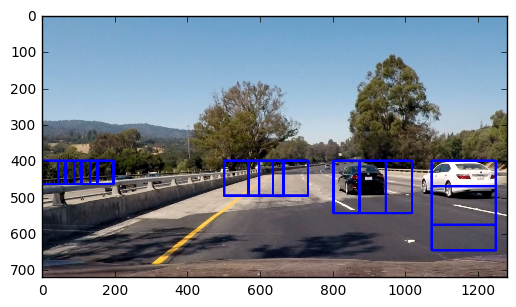

In [474]:
#Deciding the window scale and position of each scale in the image

image = mpimg.imread('./test_images/test4.jpg')
draw_image = np.copy(image)

if (np.max(image) > 1):
    #it is being read in a 0-255 scale. whereas, our training was in 0-1 scale. so it should be rescaled.
    image = image.astype(np.float32)/255

#16*4
windows = (slide_window(image, x_start_stop=[0, 256], y_start_stop=[400,500], 
                    xy_window=(64, 64), xy_overlap=(0.3, 0.3)))
#16*6
windows.extend(slide_window(image, x_start_stop=[500, 800], y_start_stop=[400,600], 
                    xy_window=(96, 96), xy_overlap=(0.3, 0.3)))
#16*9
windows.extend(slide_window(image, x_start_stop=[800, 1050], y_start_stop=[400,600], 
                    xy_window=(144, 144), xy_overlap=(0.5, 0.5)))
#16*11
windows.extend(slide_window(image, x_start_stop=[1070, None], y_start_stop=[400,650], 
                    xy_window=(176, 176), xy_overlap=(0.4, 0.6)))

image_with_windows = draw_boxes(draw_image,windows)
plt.imshow(image_with_windows)
plt.imsave('./output_images_from_pipeline/windows_visualized_to_check_scale.png',image_with_windows)


#### Happy with the scale of the windows and how they fit on the image. The overlap parameter was set to low values for easy visualization. It will be increased to 0.75 or 0.8 for actual detection process.

### 4. Sliding Window on one image

Above, in step3, we generated and visualized windows on a test image and decided the parameters which are good for our application. Now, in this step, we will perform the sliding window detection on one image and see which windows are detected as cars. The output is visualized at the end of the block.

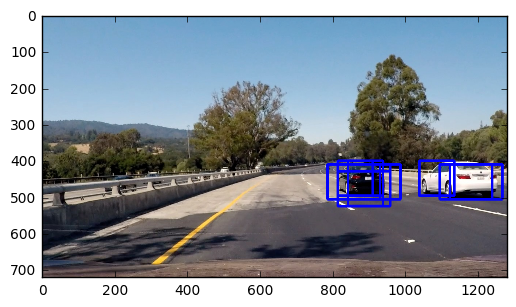

In [475]:
# Now use the windows and search for cars in one image

image = mpimg.imread('./test_images/test4.jpg')

draw_image = np.copy(image)
if (np.max(image) > 1):
    #it is being read in a 0-255 scale. whereas, our training was in 0-1 scale. so it should be rescaled.
    image = image.astype(np.float32)/255

    
windows= (slide_window(image, x_start_stop=[None, None], y_start_stop=[400,550], 
                    xy_window=(96, 96), xy_overlap=(0.7, 0.7)))
#16*9
windows+= (slide_window(image, x_start_stop=[None, None], y_start_stop=[390,580], 
                    xy_window=(144, 144), xy_overlap=(0.7, 0.7)))
#16*11
windows+= (slide_window(image, x_start_stop=[None, None], y_start_stop=[410,580], 
                    xy_window=(144, 96), xy_overlap=(0.8, 0.8)))


spatial_size=(spatial, spatial)
hist_bins=histbin
spatial_feat = True
hist_feat = True
hog_feat = True

hot_windows = search_windows(image, windows, svc, X_scaler, color_space='HSV', 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)    

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
plt.imsave('./output_images_from_pipeline/windows_detected.png',window_img)

#### Pretty decent output. Next up, is to generate a heatmap image to merge the multiple detections into a single bounding box.

### 5. Generate Heatmap and merge overlapping boundign boxes into one all encompassing box

From the sliding window output, next step is to merge the overlapping detections so that we can draw one bounding box over a single detection of car class. I do this by using heatmap image technique as taught in the lecture. The functions for the same, and their application on the above sliding window output is as in the below cell.

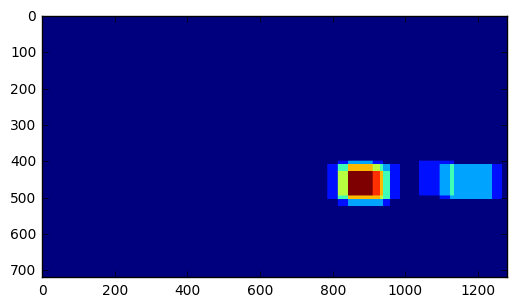

In [476]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

heatmap_win_image = add_heat(heat,hot_windows)
plt.imshow(heatmap_win_image)
plt.imsave('./output_images_from_pipeline/windows_detections_into_heatmap.png',heatmap_win_image)

#### Now the heatmap is ready, merge the boxes

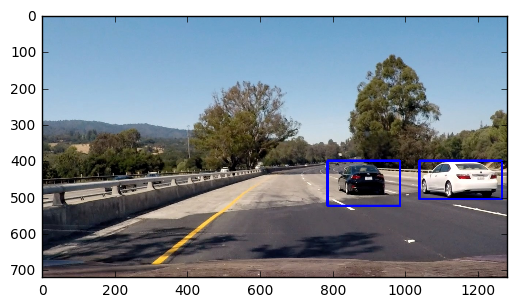

In [477]:
labels = label(heatmap_win_image)

output_image = draw_labeled_bboxes(draw_image,labels)
plt.imshow(output_image)
plt.imsave('./output_images_from_pipeline/merged_windows.png',output_image)

### 6. Apply the above develope pipeline to video

The sequentialness of video gives us more space to make the detections better. instead of generating heatmap (and hence bounding box for each object) only from each frame data, we can average over a specific set of frames and threshold accordingly, so that spurious detections that might come up in single frames are smoothened out by averaging. The class heatImage is just to track the heatmaps across frames so that we can average them for smoother detections.

In [ ]:
class heatImage():
    def __init__(self,num_Frames = 5,imgwidth = 1280,imgheight=720):
        self.accumulated_heat = np.zeros((num_Frames,imgheight,imgwidth))
        self.index = 0
        self.accumulator_full = False
        self.num_Frames = num_Frames
    
    def accumulate_heat(self,heatimg):
        self.accumulated_heat[self.index] = heatimg
        self.index = (self.index + 1)% self.num_Frames
        if self.index == 0:
            self.accumulator_full = True            
    
    def get_average_heat(self):
        if self.accumulator_full == True:
            return np.mean(self.accumulated_heat, axis = 0)
        else:
            return self.accumulated_heat[self.index-1]

def process_image(image):
    draw_image = np.copy(image)
    
    if (np.max(image) > 1):
    #it is being read in a 0-255 scale. whereas, our training was in 0-1 scale. so it should be rescaled.
        image = image.astype(np.float32)/255
    
    #16*6
    windows= (slide_window(image, x_start_stop=[None, None], y_start_stop=[400,550], 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75)))
    #16*9
    windows+= (slide_window(image, x_start_stop=[None, None], y_start_stop=[390,580], 
                    xy_window=(144, 144), xy_overlap=(0.75, 0.75)))
    #16*11
    windows+= (slide_window(image, x_start_stop=[None, None], y_start_stop=[410,580], 
                    xy_window=(128, 96), xy_overlap=(0.6, 0.6)))
    
    spatial_size=(spatial, spatial)
    hist_bins=histbin
    spatial_feat = True
    hist_feat = True
    hog_feat = True
    
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space='HSV', 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap_win_image = add_heat(heat,hot_windows)
    heatObject.accumulate_heat(heatmap_win_image)
    
    if heatObject.accumulator_full == True:
        heatmap_avg_img = heatObject.get_average_heat()
    else:
        heatmap_avg_img = heatmap_win_image
    
    heat_threshold = 1.3
    heatmap_threshold = apply_threshold(heatmap_avg_img,heat_threshold)
    labels = label(heatmap_threshold)
    final_output = draw_labeled_bboxes(draw_image,labels)
    
    return final_output
    

In [420]:
#Process the test video
from moviepy.editor import VideoFileClip

heatObject = heatImage()

clip1 = VideoFileClip('../CarND-Advanced-Lane-Lines/project_video.mp4')#.subclip(40,43) # Original video
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip.write_videofile('./project_video_output.mp4', audio=False);

[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4









  0%|          | 0/1261 [00:00<?, ?it/s]






  0%|          | 1/1261 [00:02<46:14,  2.20s/it]






  0%|          | 2/1261 [00:04<46:25,  2.21s/it]






  0%|          | 3/1261 [00:06<45:17,  2.16s/it]






  0%|          | 4/1261 [00:08<43:40,  2.08s/it]






  0%|          | 5/1261 [00:10<42:33,  2.03s/it]






  0%|          | 6/1261 [00:12<42:07,  2.01s/it]






  1%|          | 7/1261 [00:14<42:34,  2.04s/it]






  1%|          | 8/1261 [00:16<41:30,  1.99s/it]






  1%|          | 9/1261 [00:18<40:56,  1.96s/it]






  1%|          | 10/1261 [00:20<40:33,  1.95s/it]






  1%|          | 11/1261 [00:21<40:15,  1.93s/it]






  1%|          | 12/1261 [00:23<39:55,  1.92s/it]






  1%|          | 13/1261 [00:25<39:40,  1.91s/it]






  1%|          | 14/1261 [00:27<39:31,  1.90s/it]






  1%|          | 15/1261 [00:29<39:25,  1.90s/it]






  1%|▏         | 16/1261 [00:31<39:23,  1.90s/it]






  1%|▏         | 17/1261 [00:33<39:14,  1.89s/it]






  1

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 



### Conclusion

1. This project was a nice introduction to classical computer vision (data based techninques) which involved ingenious methods of deriving relevant features from images for a given task, until this process is being beaten hands-down in most the scenarios today after the advent of deep learning. But, as suggested in the lecture material, it is very relevant to know these techniques, as it gives more intuition into designing vison systems and understanding the behaviors, rather than looking at a black box (to an extent) like deep learning.

2. The pipeline took a lot of time to design the window shape, size and number. A tradeoff occurs where, if we reduce the sheer number of windows we test for 'carness', we get faster processing but not so good results. On the otherhand, if we increase the number of windows, we get decent results but the processing is painfully slow. Here, I have erred a bit on the higher number of windows side, as my primary goal in this assignment was to identify cars in an image as accurately as possible.

3. But, again this sort of a slow processing bulk of a pipline, is not practical in the same sense it is being implemented. A few techniques which I think could help in detection is if we can have a layered approach to testing, where if we can map out few areas which are most proable to yield cars for us for a given image, then we can concentrate our windows more in these regions, and reduce the density of the windows in the other regions yielding to faster processing of each frame.

4. But, howmuchever you increase the processing speed of each frame, some fundamental calculations have to done because of the nature of the detection method. So, it is bound to take time. What would be interesting, is to include tracking into this. Once, we have detected our objects with high certainity in a frame, for maybe next 10 frames we dont need to detect more objects, since we will not see that big of a change in 10 frames (0.4s), and we can just track the objects instead. Looking forward to learning tracking in Term2 and see how it could improve the practicality of this method of detection!